In [1]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

import scipy.fftpack

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [17]:
#Get some data
dirName="/Users/rjn/dune/data/preampCalibration_10052022/"
#fileBase="preampA_473nF_captest_oneleg_take2"
#fileBase="preampA_473nF_captest_inbox_oneleg"
#fileBase="preampA_473nF_captest_15MOhm_resistor"
#fileBase="preampA_473nF_captest_15MOhm_resistor_lidscrewedon"
#fileBase="preampA_473nF_captest_15MOhm_resistor_lidscrewedon_take2"
#fileBase="preampA_473nF_captest_oneleg_boxopen"
#fileBase="preampA_473nF_captest_oneleg_boxclosed"
#fileBase="preampA_473nF_captest_oneleg_boxclosed_screwson_all"
fileBase='preampA_473nF_captest_1GOhm_lidscrewedon_take3'
inputList,timeList=ppt.getScopeWaveforms(dirName+fileBase+".ch4.traces",False)
outputList,timeList=ppt.getScopeWaveforms(dirName+fileBase+".ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width1us_0_100mV.ch3.traces",False)
#inputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch4.traces",False)
#outputList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/data/pulserTest_03052022/width100ns_0_300mV_ampScan.ch3.traces",False)

(1000, 5002) (1000, 5002) (5002,)


Text(0, 0.5, 'Voltage (Volts)')

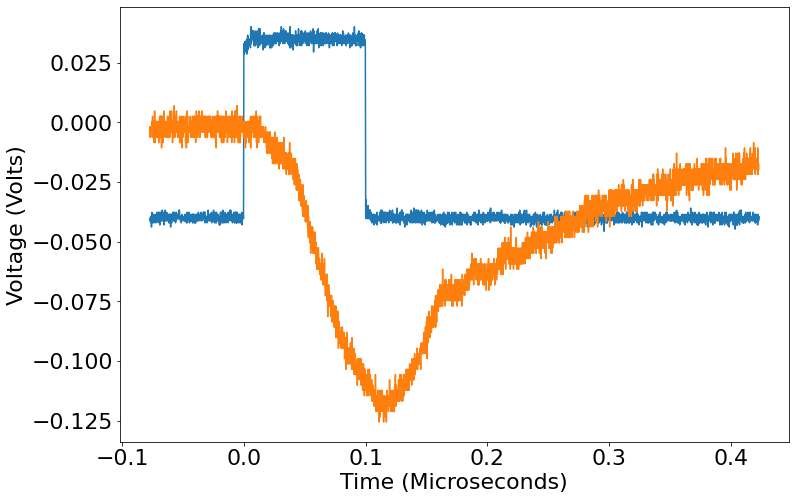

In [3]:
print(outputList.shape,inputList.shape,timeList.shape)

#Plot the first waveforms
fig, ax = plt.subplots()
ax.plot(timeList,inputList[0],label="Input Pulse")
ax.plot(timeList,outputList[0],label="Preamp Output")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")

Text(0, 0.5, 'Peak Size (max -min)')

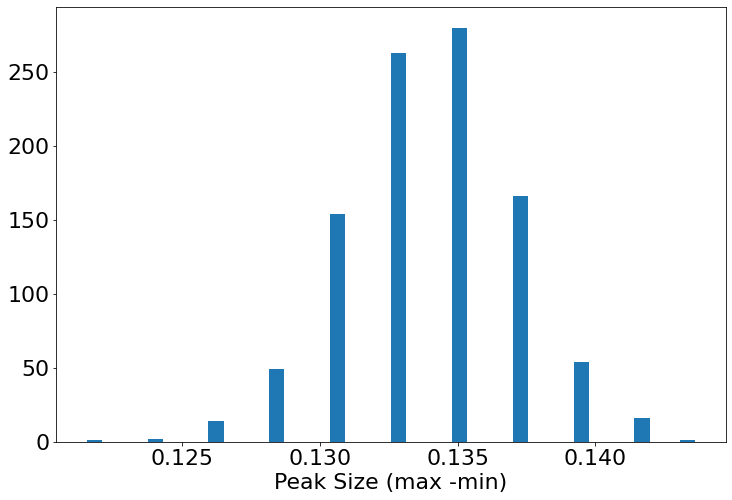

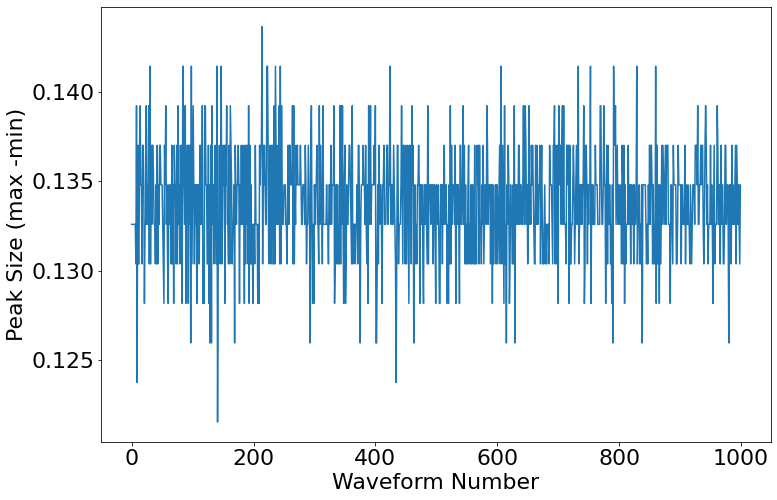

In [4]:
minVal=np.min(outputList,axis=1)
maxVal=np.max(outputList,axis=1)

fig, ax = plt.subplots()
ax.hist(maxVal-minVal,bins=40)
ax.set_xlabel("Peak Size (max -min)")


fig, ax = plt.subplots(facecolor='white')
ax.plot(range(len(maxVal)),maxVal-minVal)
ax.set_xlabel("Waveform Number")
ax.set_ylabel("Peak Size (max -min)")



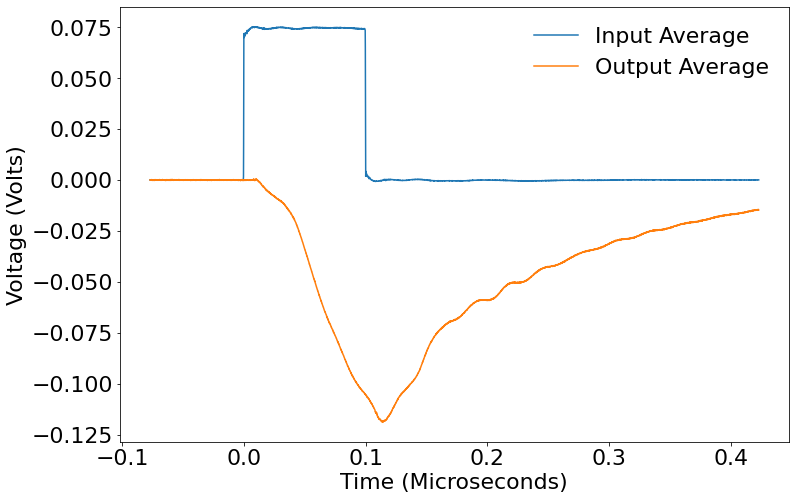

In [5]:
dt=timeList[1]-timeList[0]
fs=1./dt

inputAvg=np.mean(inputList,axis=0)
outputAvg=np.mean(outputList,axis=0)
inputAvg-=np.mean(inputAvg[0:100])
outputAvg-=np.mean(outputAvg[0:100])
#print(inputAvg.shape)

inputSmooth=ppt.butter_lowpass_filter(inputList[0],1000,fs,2)
outputSmooth=ppt.butter_lowpass_filter(outputList[0],1000,fs,2)

fig, ax = plt.subplots()
#ax.plot(timeList,inputSmooth,label="Input Smooth")
#ax.plot(timeList,outputSmooth,label="Output Smooth")
ax.plot(timeList,inputAvg,label="Input Average")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()


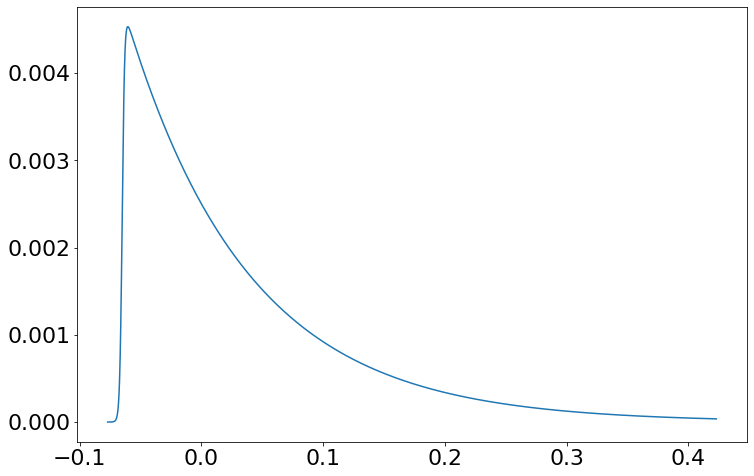

In [6]:
#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response2(x,offset,tau,tauRise,norm):
    return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function

#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response(x,offset,tau,norm):
    conds = [x<0,(x>=0) & (x < offset), x>=offset]   #The two regions of x
    funcs = [lambda x: 0, lambda x:0, lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it


offset=timeList[120]
tau=0.1
tauRise=0.001
norm=0.0025
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response2(timeList[0:10000],offset,tau,tauRise,norm),label="Response Function")



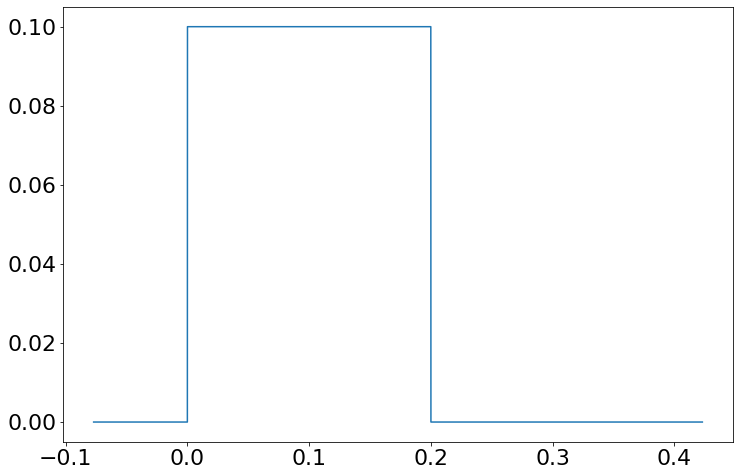

In [7]:
#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def fakePulse(x,start,width,sigma,norm):
    conds = [x<start-6*sigma,
             (x>=start-6*sigma) & (x < start + 6*sigma),
             (x>start + 6*sigma) & (x<=width+start - 6*sigma),
             (x>width+start - 6*sigma) & (x<=width+start + 6*sigma),
             (x>width+start + 6*sigma)]   #The two regions of x
    funcs = [lambda x: 0, 
             lambda x: norm / (1 + np.exp(- (x-start)/sigma)), 
             lambda x: norm,
            lambda x:  norm-(norm / (1 + np.exp(- (x-start-width)/sigma))),
            lambda x: 0]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it


start=0
tau=0.1
norm=0.1
width=0.2
sigma=0.0
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],fakePulse(timeList[0:10000],start,width,sigma,norm),label="Fake Pulse")

[-6.28441059e-02  1.46313452e-01  2.24836071e-07 -1.33199250e-03]


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78268/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function
/Users/rjn/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78268/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


Text(0.25, -0.10696255247790366, 'norm=-0.00133')

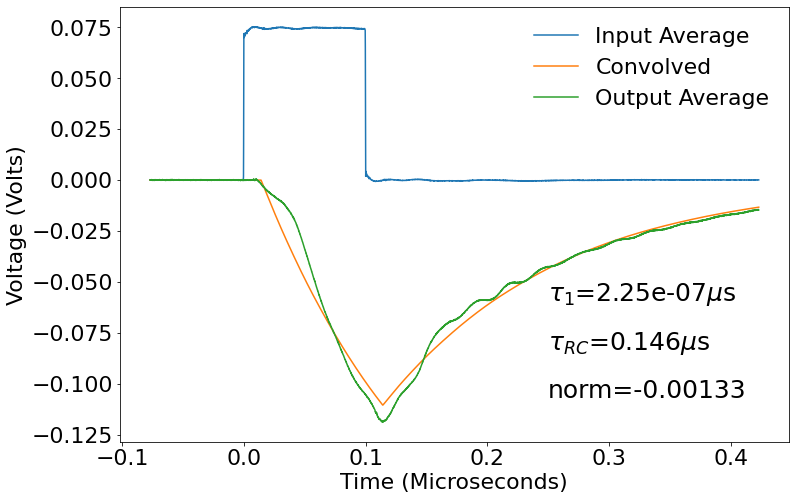

In [8]:
def func(xdata,offset,tau,norm):
    return signal.convolve(xdata, response(timeList[0:10000],offset,tau,norm), mode='full')[0:len(xdata)] 

def func2(xdata,offset,tau,tauRise,norm):
    return signal.convolve(xdata, response2(timeList[0:10000],offset,tau,tauRise,norm), mode='full')[0:len(xdata)] 

import scipy.signal as signal
from scipy.optimize import curve_fit
#popt, pcov = curve_fit(func, inputAvg, outputAvg,p0=[offset,tau,-1*norm])
popt, pcov = curve_fit(func2, inputAvg, outputAvg,p0=[offset,tau,tauRise,-1*norm])
print(popt)
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
#ax.plot(timeList,inputSmooth,label="2nd Order")
ax.plot(timeList,func2(inputAvg,popt[0],popt[1],popt[2],popt[3]),label="Convolved")
#ax.plot(timeList,func(fakePulse(timeList,start,width,sigma,norm),popt[0],popt[1],popt[2]),label="Convolved With Fake")
ax.plot(timeList,outputAvg,label="Output Average")

ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()

minVal=np.min(outputAvg)

textLabel=r"$\tau_1$="+f"{popt[2]:1.3g}"+"$\mu$s"
plt.text(0.25, minVal*0.5, textLabel, fontsize=25)
textLabel=r"$\tau_{RC}$="+f"{popt[1]:1.3g}"+"$\mu$s"
plt.text(0.25, minVal*0.7, textLabel, fontsize=25)#ax.set_xlim(-0.01,0.111)
textLabel=r"norm="+f"{popt[3]:1.3g}"
plt.text(0.25, minVal*0.9, textLabel, fontsize=25)#ax.set_xlim(-0.01,0.111)



/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78268/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


Text(0, 0.5, 'Response (units?)')

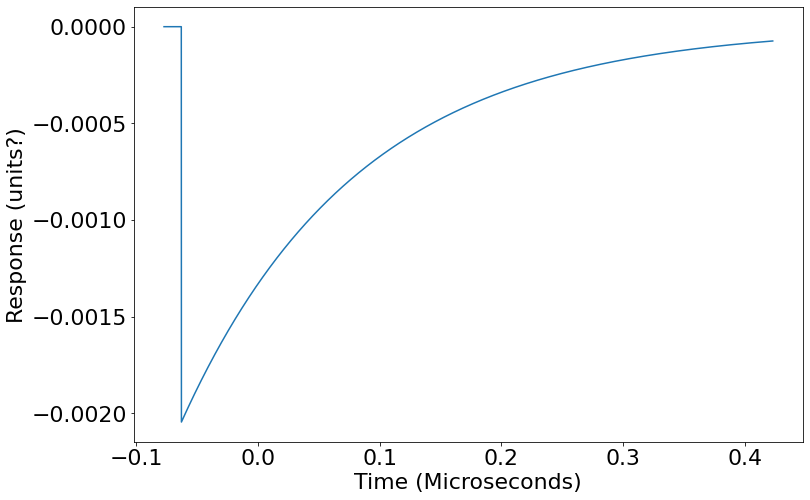

In [9]:

    
fig, ax = plt.subplots(facecolor='white')
ax.plot(timeList[0:10000],response2(timeList[0:10000],popt[0],popt[1],popt[2],popt[3]),label="Response Function")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Response (units?)")

In [55]:
outputAvgf = scipy.fftpack.fft(outputAvg)
inputAvgf = scipy.fftpack.fft(inputAvg)
responsef = scipy.fftpack.fft(response2(timeList,popt[0],popt[1],popt[2],popt[3]))
hopedinputf=outputAvgf/responsef
fakeout=inputAvgf*responsef
fakeresponse=outputAvgf/inputAvgf

print(np.shape(outputAvgf),np.shape(outputAvg))
print(np.sum(outputAvg**2), np.sum(np.abs(outputAvgf)**2)/len(outputAvg))

#Convert to dB... relative to 1.0
def convertTodB(cVals):
    N=len(cVals) 
    newVals=np.abs(cVals[:N//2])**2
    newVals[1:-2]*=2
    return 10*np.log10(newVals/N)





(5002,) (5002,)
13.710943646363159 13.710943646363164


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78268/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


(5002,) (5002,) (2501,)
[0.00894822-0.00281339j 0.00471977+0.00137842j 0.00719488-0.j
 0.00471977-0.00137842j 0.00894822+0.00281339j]


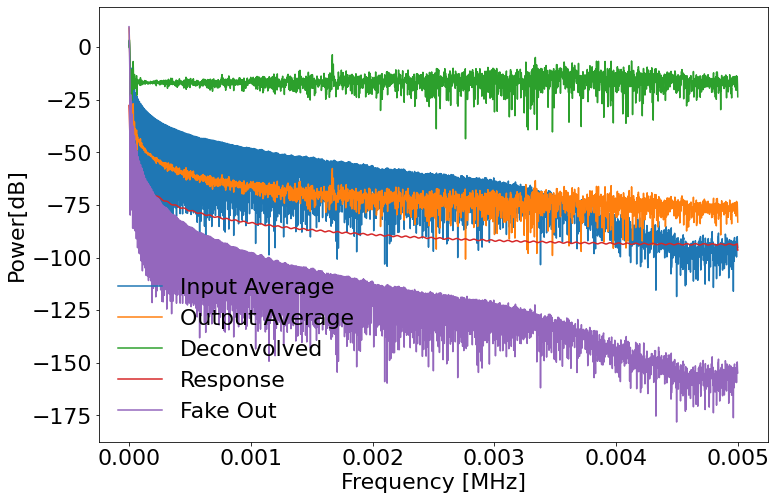

In [56]:
xf = np.linspace(0.0, 1e-6/(2.0*dt), int((len(outputAvg))/2))

#fig,ax=plt.subplots()
#ax.plot(np.arange(len(outputAvgf)),outputAvgf)
print(np.shape(outputAvgf),np.shape(outputAvg),np.shape(convertTodB(outputAvgf)))
print(outputAvgf[2499:2504])
fig, ax = plt.subplots()
ax.plot(xf,convertTodB(inputAvgf),label="Input Average")
ax.plot(xf,convertTodB(outputAvgf),label="Output Average")
ax.plot(xf,convertTodB(hopedinputf),label="Deconvolved")
ax.plot(xf,convertTodB(responsef),label="Response")
ax.plot(xf,convertTodB(fakeout),label="Fake Out")
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Power[dB]")
ax.legend()

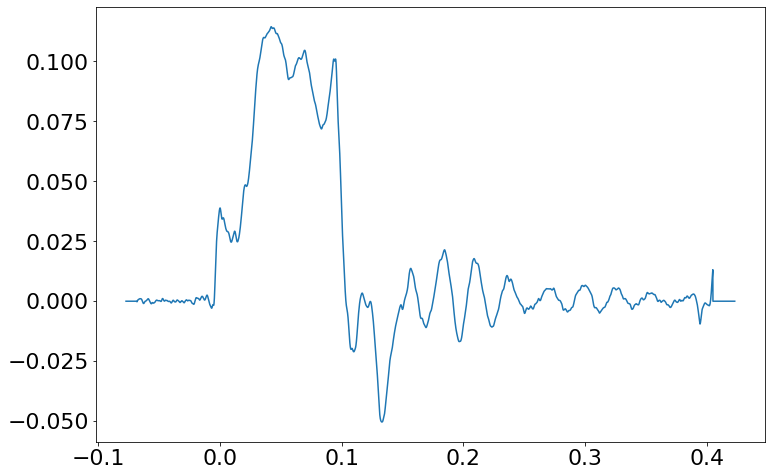

In [12]:
fakeoutTime=scipy.fftpack.ifft(fakeout)
fakeinTime=scipy.fftpack.ifft(hopedinputf)
fig, ax = plt.subplots()
#ax.plot(timeList,fakeoutTime,label="Fake Output")
fakeinSmooth=ppt.butter_lowpass_filter(fakeinTime,200,fs,2)
fakeinSmooth.real[0:90]=0
fakeinSmooth.real[-180:]=0
fakeinSmooth=fakeinSmooth.real
ax.plot(timeList,fakeinSmooth,label="Fake Input")
#ax.set_ylim(-1,1)



/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78268/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78268/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


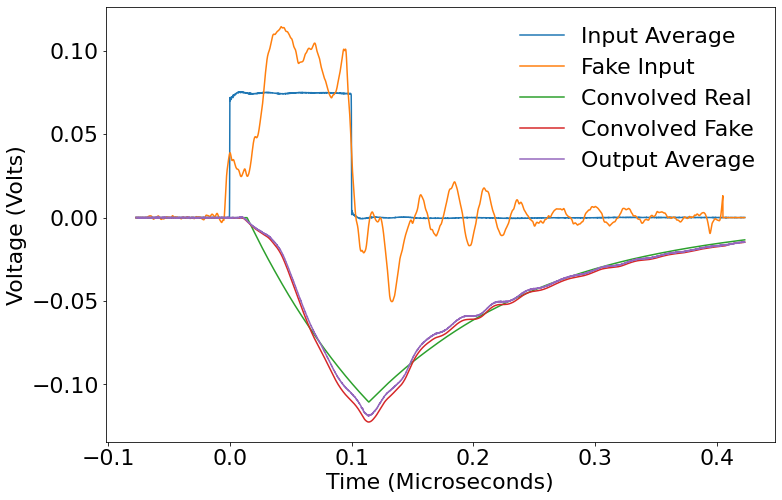

In [13]:
fig, ax = plt.subplots()
ax.plot(timeList,inputAvg,label="Input Average")
ax.plot(timeList,fakeinSmooth,label="Fake Input")
ax.plot(timeList,func2(inputAvg,popt[0],popt[1],popt[2],popt[3]),label="Convolved Real")
ax.plot(timeList,func2(fakeinSmooth,popt[0],popt[1],popt[2],popt[3]),label="Convolved Fake")
#ax.plot(timeList,func(fakePulse(timeList,start,width,sigma,norm),popt[0],popt[1],popt[2]),label="Convolved With Fake")
ax.plot(timeList,outputAvg,label="Output Average")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()

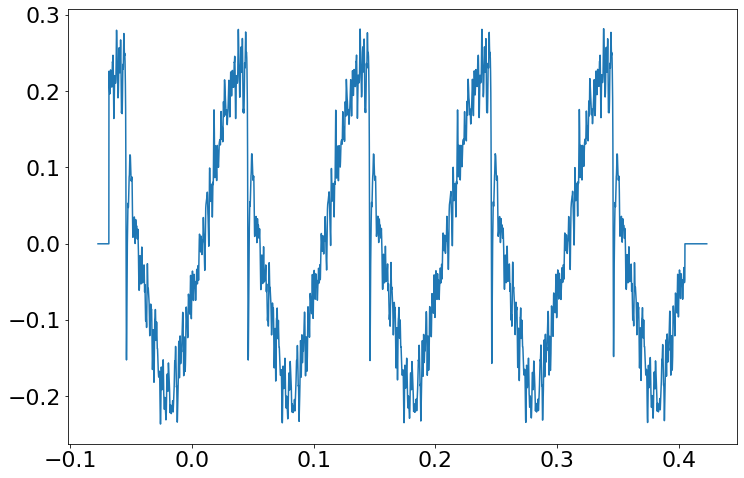

In [14]:
fakerepTime=scipy.fftpack.ifft(fakeresponse)
fig, ax = plt.subplots()
#ax.plot(timeList,fakeoutTime,label="Fake Output")
fakerepSmooth=ppt.butter_lowpass_filter(fakerepTime,1000,fs,2)
fakerepSmooth.real[0:90]=0
fakerepSmooth.real[-180:]=0
fakerepSmooth=fakerepSmooth.real
ax.plot(timeList,fakerepSmooth,label="Fake Response")

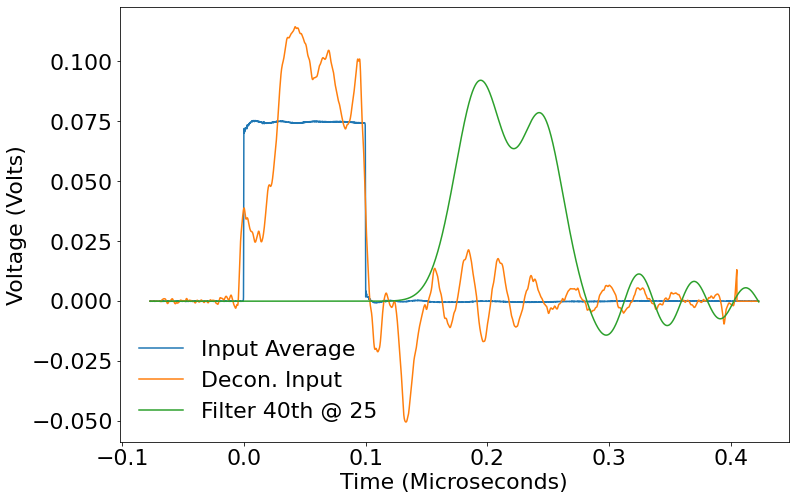

In [57]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(timeList,inputAvg,label="Input Average")
ax.plot(timeList,fakeinSmooth,label="Decon. Input")
ax.plot(timeList,ppt.butter_lowpass_sosfilter(inputAvg,25,fs,40),label="Filter 40th @ 25")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()



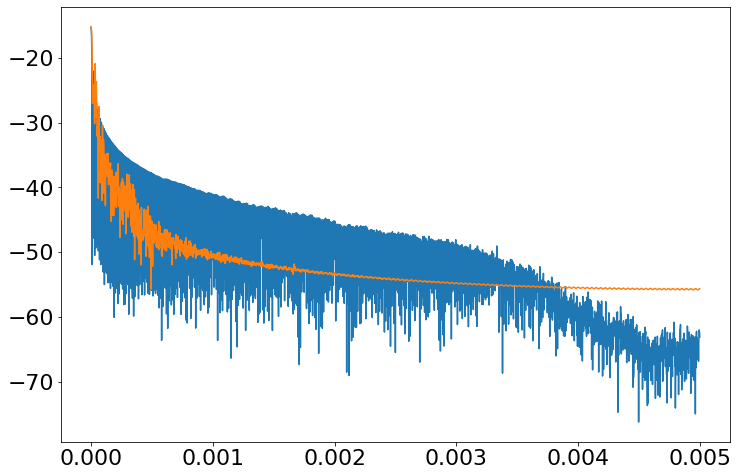

In [16]:
inputAvgf = scipy.fftpack.fft(inputAvg)
fakeSmoothf = scipy.fftpack.fft(fakeinSmooth)
fig, ax = plt.subplots()
ax.plot(xf,convertTodB(inputAvgf),label="Input Average")
ax.plot(xf,convertTodB(fakeSmoothf),label="Fake Smooth")